<a href="https://colab.research.google.com/github/neuromatch/course-content-template/blob/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/course-content-template/main/tutorials/W1D2_Template/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 4: Biological meta reinforcement learning  

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]

___


# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

In this tutorial, you will observe how meta reinforcement learning may be occurring in the brain.



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today


## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

# print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup



In [2]:
# @title Install and import feedback gadget

# !pip3 install vibecheck datatops --quiet

# from vibecheck import DatatopsContentReviewContainer
# def content_review(notebook_section: str):
#     return DatatopsContentReviewContainer(
#         "",  # No text prompt - leave this as is
#         notebook_section,
#         {
#             "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
#             "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
#             "user_key": "y1x3mpx5",
#         },
#     ).render()

# feedback_prefix = "W2D4_T4"

In [3]:
# Imports

#working with data
import numpy as np
import random

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_cumulative_rewards(rewards):
    """
    Plot the cumulative rewards over time.

    Inputs:
    - rewards (list): list containing the cumulative rewards at each time step.
    """
    with plt.xkcd():
        plt.plot(range(len(rewards)), rewards)
        plt.xlabel('Time Step')
        plt.ylabel('Cumulative Reward')
        plt.title('Cumulative Reward Over Time')
        plt.show()
        

def plot_boxplot_scores(scores):
    """
    Plots a boxplot of the given scores.
    
    Inputs:
    scores (list): list of scores.
    """
    with plt.xkcd(): 
        plt.boxplot(scores, labels = [''])
        plt.xlabel('')
        plt.ylabel('Score')
        plt.title('Distribution of Scores')
        plt.show()

def plot_two_boxplot_scores(newbie_scores, experienced_scores):
    """
    Plots two boxplots of the given scores.
    
    Inputs:
    scores (list): list of scores.
    """
    with plt.xkcd():
        plt.boxplot([newbie_scores, experienced_scores], labels=['Newbie', 'Experienced'])
        plt.xlabel('Agent')
        plt.ylabel('Score')
        plt.title('Distribution of Scores')
        plt.show()

In [6]:
# @title Helper functions

def run_dummy_agent(env):
    """
    Implement dummy agent strategy: chooses the last rewarded action.

    Inputs:
    - env (HarlowExperimentEnv): An environment.
    """
    action = 0
    cumulative_reward = 0
    rewards = [cumulative_reward]

    for _ in (range(num_trials)):
        _, reward = env.step(action)
        cumulative_reward += reward
        rewards.append(cumulative_reward)
    
        #dummy agent 
        if reward == -1:
            action = 1 - action
    return rewards

In [9]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fname = "Evolution.pt" # The name of the file to be downloaded
url = "https://osf.io/wmvh4/download" # URL from where the file will be downloaded
expected_md5 = "d0a74898e56549f7c5206e4c8f373ced" # MD5 hash for verifying file integrity

if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [7]:
# @title Set device (GPU or CPU).

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [8]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

---

# Section 1: Harlow Experiment

In this section we will introduce the meta reinforcement learning environment which replicates the 1940s Harlow experiment and will observe its meta-nature.

In [499]:
# @title Video 1: Harlow Experiment

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_harlow_experiment")

## Coding Exercise 1: Meta-Structure 

Any RL system consists of the agent who tries to succeed in the accomplishment of the task by observing the state of the enviornment, executing an action, and receiving the outcome (reward). If aspects of the environment change with time, previously learnt hard-coded strategies might not work anymore. Still, as in the previous tutorial, these changes share similar features across the tasks. The Harlow experiment illustrates that though there is no direct instruction on how to obtain the maximum possible reward, and the environment's state changes with each new pair of the objects, the agent is still able to capture the meta-sructure of the experiment - the reward is associated with the object, not its relative placement.

In the coding exercies you should complete dynamics of the Harlow experiment environment.

In [ ]:
class HarlowExperimentEnv():
    def __init__(self, reward = 1, punishment = -1):
        """Initialize Harlow Experiment environment."""
        self.reward = reward
        self.punishment = punishment

        self.rewarded_digit = -1
        self.punished_digit = -1

        self.state = np.array([self.rewarded_digit, self.punished_digit])
        
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete state update and choose appropriate feedback based on the condition.")
    ###################################################################
    def update_state(self):
        """Update state by selecting rewarded hand for random."""
        if np.random.rand() < 0.5:
            self.state = np.array([self.rewarded_digit, ...])
        else:
            self.state = np.array([self.punished_digit, ...])

    def reset(self):
        """Reset environment by updating new rewarded and punished digits as well as create current state of the world (tuple of observations)."""
        self.rewarded_digit, self.punished_digit = np.random.choice(10, 2, replace=False)
        self.update_state()
        return self.state

    def step(self, action):
        """Evaluate agent's perfromance, return reward and next observation."""
        if self.state[action] == self.rewarded_digit:
            feedback = ...
        else:
            feedback = ...
        self.update_state()
        return self.state, feedback

In [10]:
# to_remove solution

class HarlowExperimentEnv():
    def __init__(self, reward = 1, punishment = -1):
        """Initialize Harlow Experiment environment."""
        self.reward = reward
        self.punishment = punishment

        self.rewarded_digit = -1
        self.punished_digit = -1

        self.state = np.array([self.rewarded_digit, self.punished_digit])

    def update_state(self):
        """Update state by selecting rewarded hand for random."""
        if np.random.rand() < 0.5:
            self.state = np.array([self.rewarded_digit, self.punished_digit])
        else:
            self.state = np.array([self.punished_digit, self.rewarded_digit])

    def reset(self):
        """Reset environment by updating new rewarded and punished digits as well as create current state of the world (tuple of observations)."""
        self.rewarded_digit, self.punished_digit = np.random.choice(10, 2, replace=False)
        self.update_state()
        return self.state

    def step(self, action):
        """Evaluate agent's perfromance, return reward and next observation."""
        if self.state[action] == self.rewarded_digit:
            feedback = self.reward
        else:
            feedback = self.punishment
        self.update_state()
        return self.state, feedback

Let's evaluate a simple strategy for this task: an agent always chooses the side that was previously rewarded (meaning it stays with the same hand if it received reward and changes its action if it was punished). Do you think this agent uses information about the current state? How much cumulative reward do you expect this "dummy" agent to get?

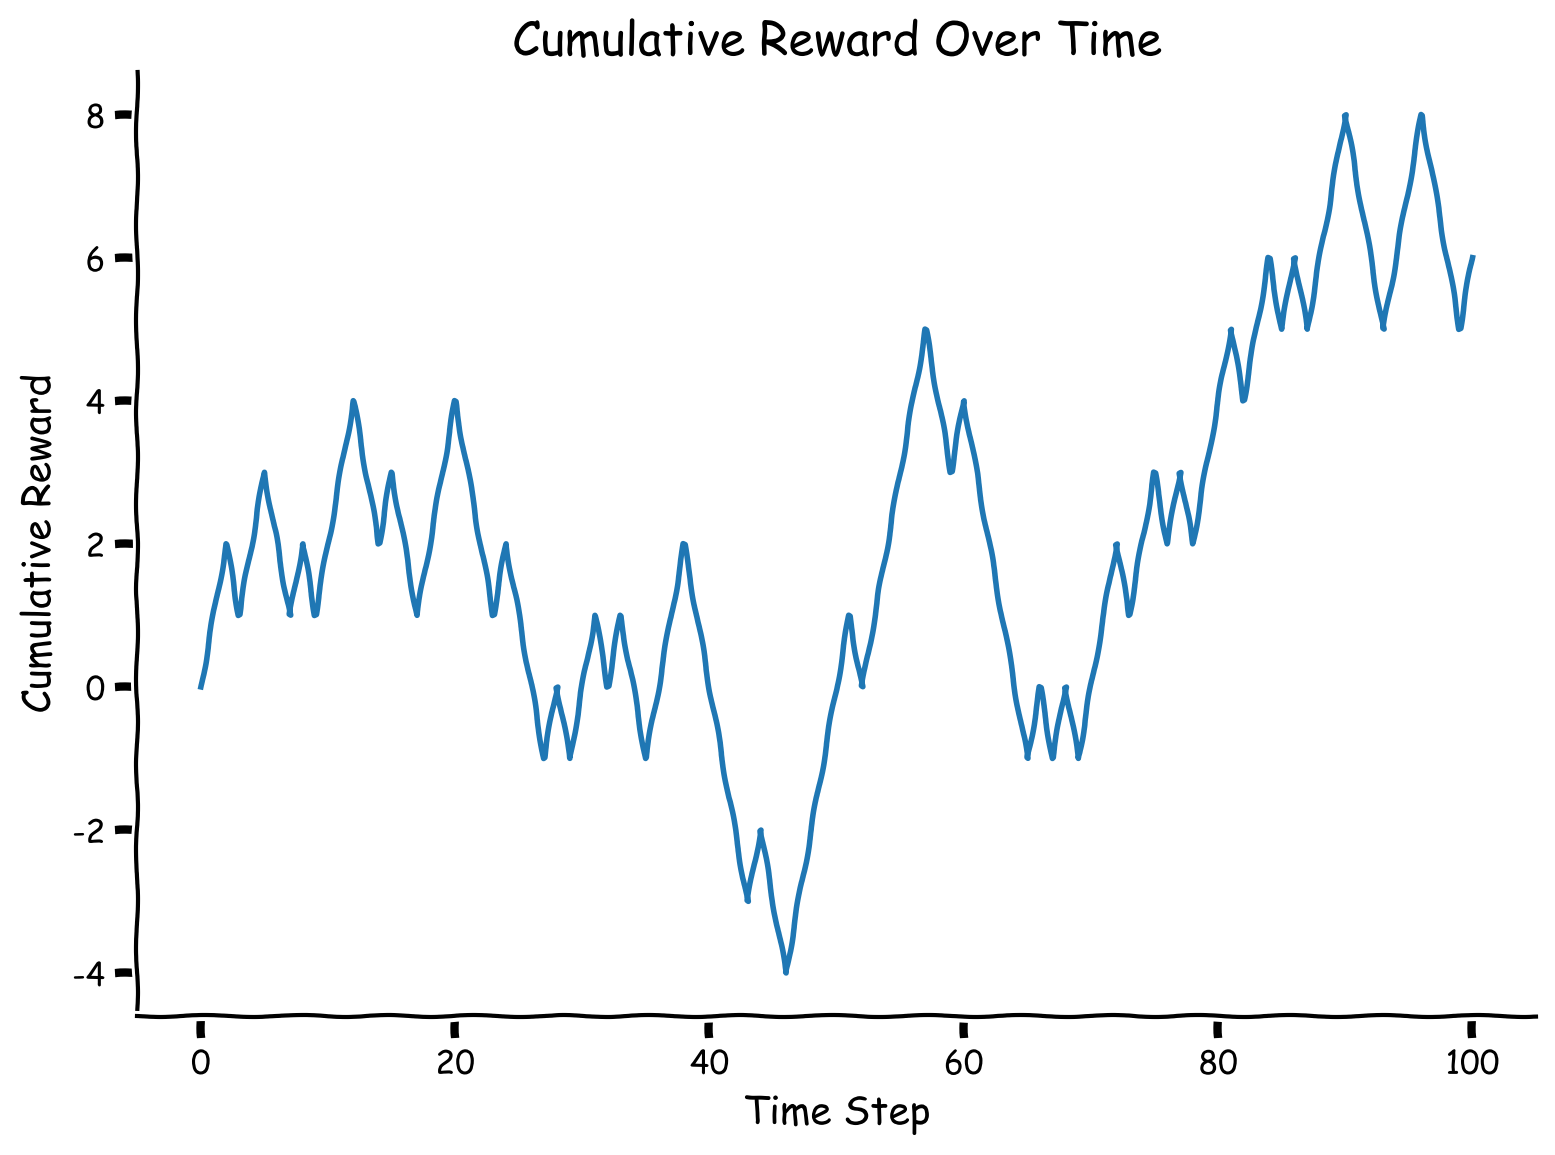

In [11]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)
num_trials = 100
env = HarlowExperimentEnv()
env.reset()
rewards = run_dummy_agent(env)
        
plot_cumulative_rewards(rewards)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_meta_environment")

---

# Section 2: Advantage Actor Critic (A2C) Agent

*Estimated timing to here from start of tutorial: 10 minutes*

Let's see if we can do better than the dummy agent's strategy. After defining the environment and observing the behaviour of the agent implementing such a simple policy, it is the right time to remind ourselves about more sophisticated agent architectures that are capable of learning the environment's dynamics. For this we will use the Advantage Actor Critic (A2C).

The main idea behind A2C, as it name suggests, is that it consists of two networks, named actor and critic. Actor network learns the policy (mapping states to actions), while the critic network learns the value function (estimating the expected future rewards from a given state). In the most cases, they share the same "body" and only the last linear projection to the output is specific to each of the networks. The "advantage" term comes from the training step: instead of raw rewards, in A2C we calculate the advantage function, which estimates how much better or worse an action is compared to the average action value for a given state.

The architecture of the agent is the following: it receives the previous state, previous reward & chosen action as input, which is linearly projected to the `hidden_size` (this creates an embedding); then, its core consists of recurrent `LSTM` cells, their number is exactly `hidden_size`. Right after this RNN layer there are two distinct linear projections: one for the actor (output dimension coincides with the number of actions; for the Harlow experiment it is 2) and the latter for critic (outputs one value).

We don't propose an exercise to code for the agent, simply go through the cell below to understand the implementation.

In [12]:
class ActorCritic(nn.Module):
    def __init__(self, hidden_size, num_inputs = 5, num_actions = 2):
        """Initialize Actor-Critic agent."""
        super(ActorCritic, self).__init__()

        #num_actions is 2 because left/right hand
        self.num_actions = num_actions

        #num_inputs is 5 because one-hot encoding of action (2) + reward (1) + previous state (2)
        self.num_inputs = num_inputs 
        
        self.hidden_size = hidden_size

        #hyperparameters involved in training (important to keep assigned to the agent)
        self.learning_rate = 0.00075 #learning rate for optimizer
        self.discount_factor = 0.91 #gamma
        self.state_value_estimate_cost = 0.4 #beta_v
        self.entropy_cost = 0.001 #beta_e

        self.emb = nn.Linear(num_inputs, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size)
        self.critic_linear = nn.Linear(hidden_size, 1)
        self.actor_linear = nn.Linear(hidden_size, num_actions)


    def forward(self, state, h, c):
        """Implement forward pass through agent."""
        #at first, input goes through embedding
        state = self.emb(state.unsqueeze(0))

        #then through RNNs (observe that we pass hidden states too!)
        state, hidden_states = self.rnn(state.unsqueeze(0), (h, c))
        state = state.squeeze(0)
        h, c = hidden_states
        state = state.squeeze(0)

        #critic -> value
        value = self.critic_linear(state)

        #actor -> policy
        policy_logits = self.actor_linear(state)

        return value, policy_logits, (h, c)

    def get_init_hidden_states(self, batch_size=1, device = device):
        """Initialize hidden state with 0."""
        #initialize hidden state in RNNs
        return (torch.zeros(1, batch_size, self.hidden_size).to(device), torch.zeros(1, batch_size, self.hidden_size).to(device))

In the cell below we define the training procedure for the A2C agent as well as its evaluation afterwards. The function `train_evaluate_agent` performs `num_gradient_steps` gradient steps (by default - 25) and for each of the steps, the agent is exposed to the enviornment's states sequence of length `num_trials`  (by default - 6, as in classical Harlow experiment). Each gradient step, it performs backpropagation of the loss for these 6 trials by calculating advantage and weighting actor and critic losses with the entropy of the policy (for more information, please refer to [this resource](https://www.biorxiv.org/content/10.1101/295964v1.full.pdf), p.14). After the training is complete, the evaluation phase starts, gathering rewards for `num_evaluation_trials` trials (by default - 20). Note: the evaluation is completed on the same task.

In [13]:
def train_evaluate_agent(env, agent, optimizer_func, num_gradient_steps = 25, num_trials = 6, num_evaluation_trials = 20):
    """Training and evaluation for agent in Harlow experiment environment.
    Evaluation goes only after all gradient steps.
    
    Inputs:
    - env (HarlowExperimentEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - num_gradient_steps (int, default = 25): number of gradient steps to perform.
    - num_trials (int, default = 6): number of times the agent is exposed to the environment per gradient step to be trained .
    - num_evaluation_trials (int, default = 20): number of times the agent is exposed to the environment to evaluate it (no training happend during this phase).

    Outputs:
    - score (int): cumulative reward over all trials of evaluation.
    """
    #training

    #reset environment
    state = env.reset()

    #define optimizer
    optimizer = optimizer_func(agent.parameters(), agent.learning_rate, eps = 1e-5)

    for _ in range(num_gradient_steps):

      #for storing variables for training
      log_probs = []
      values = []
      rewards = []
      entropy_term = torch.tensor(0.)

      #start conditions
      h, c = agent.get_init_hidden_states()
      preceding_reward = torch.Tensor([0])
      preceding_action = torch.Tensor([0, 0])

      for trial in range(num_trials):
          
          #state + reward + one-hot encoding of action
          full_state = torch.cat((torch.from_numpy(state).float(), preceding_reward, preceding_action), dim = 0)
          value, policy_logits, step_hidden_states = agent(full_state, h, c)
          h, c = step_hidden_states
          value = value.squeeze(0)
          
          #sample action from policy
          dist = torch.distributions.Categorical(logits=policy_logits.squeeze(0))
          action = dist.sample()

          #perform action to get reward and new state
          new_state, reward = env.step(action)

          #update preceding variables
          preceding_reward = torch.Tensor([reward])
          preceding_action = F.one_hot(action, num_classes=2).float()
          state = new_state

          #for training
          log_prob = dist.log_prob(action)
          entropy = dist.entropy()
          rewards.append(reward)
          values.append(value)
          log_probs.append(log_prob)
          entropy_term += entropy

      #calculataing loss
      Qval = 0
      Qvals = torch.zeros(len(rewards))
      for t in reversed(range(len(rewards))):
        Qval = rewards[t] + agent.discount_factor * Qval
        Qvals[t] = Qval
      values = torch.stack(values)
      log_probs = torch.stack(log_probs)
      advantage = Qvals - values
      actor_loss = (-log_probs * advantage.detach()).mean()
      critic_loss = advantage.pow(2).mean()
      entropy_term = entropy_term / num_trials
        
      #loss incorporates actor/critic terms + entropy
      loss = actor_loss + agent.state_value_estimate_cost * critic_loss - agent.entropy_cost * entropy_term

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #evaluation (on the same task after all gradient steps!)
    score = 0
    
    #start conditions
    h, c = agent.get_init_hidden_states()
    preceding_reward = torch.Tensor([0])
    preceding_action = torch.Tensor([0, 0])
    
    for _ in range(num_evaluation_trials):
        
      #state + reward + one-hot encoding of action
      full_state = torch.cat((torch.from_numpy(state).float(), preceding_reward, preceding_action), dim = 0)
      value, policy_logits, step_hidden_states = agent(full_state, h, c)
      h, c = step_hidden_states
      value = value.squeeze(0)

      #sample action from policy
      dist = torch.distributions.Categorical(logits=policy_logits.squeeze(0))
      action = dist.sample()
      
      #perform action to get reward and new state
      new_state, reward = env.step(action)

      #update preceding variables
      preceding_reward = torch.Tensor([reward])
      preceding_action = F.one_hot(action, num_classes=2).float()
      state = new_state
        
      #add reward to the score of agent
      score += reward

    return score

Let's see what is the score for the default A2C agent in Harlow experiment (as the number of evaluation trials is 20, the maximum score to obtain is exactly 20).

In [14]:
set_seed(42)

#define environment
env = HarlowExperimentEnv()

#define agent and optimizer
agent = ActorCritic(hidden_size = 20)
optimizer_func = optim.RMSprop

#calculate score
score = train_evaluate_agent(env, agent, optimizer_func)
print(f"Score is {score}.")

Score is 12.


Can we think of a way to make the network better at this learning Harlow tasks?

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_a2c_agent")

---

# Section 3: Baldwin Effect

*Estimated timing to here from start of tutorial: 25 minutes*

This section discusses the Baldwin effect in evolutionary biology and proposes you to code for its implementation.

In [ ]:
# @title Video 2: Baldwin Effect

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

# video_ids = [('Youtube', '<video_id_1>'), ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
# tab_contents = display_videos(video_ids, W=854, H=480)
# tabs = widgets.Tab()
# tabs.children = tab_contents
# for i in range(len(tab_contents)):
#   tabs.set_title(i, video_ids[i][0])
# display(tabs)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_baldwin_effect")

## Coding Exercise 2: Agent's Rate to Learn

As it was introduced in the video, the Baldwin effect argues that we don't inherit the features/weights that make us good at specific tasks but rather the ability to learn quickly to gain the needed features in the context of the tasks we face during our own lifetime. In this way, evolution works like the outer loop in a meta-learning context.

In the next section we will implement this evolutionary approach to meta-learning. But first we need to write a function that lets us evaluate how well an agent can learn each instantiation of the Harlow task. This looks something like this:

$
\begin{align*}
& [1] \: \theta \: \text{- network parameters} \\
& [2] \: \text{Sample batch of tasks }\tau_i \sim p(\tau) \\
& [3] \: \text{for all }\tau_i \text{ do} \\
& [4] \: \quad\quad \theta_i \leftarrow \theta \\
& [5] \: \quad\quad \text{for} \: k \: \text{in range(number of gradient steps)}  \\
& [6] \: \quad\quad\quad\quad\text{Evaluate }\nabla_{\theta_i} \mathcal{L}_{\tau_i}(\theta_i) \\
& [7] \: \quad\quad\quad\quad\text{Compute adapted parameters with gradient descent:} \: \: \theta_i \leftarrow \theta_i - \alpha \nabla_{\theta_i} \mathcal{L}_{\tau_i}(\theta_i) \\
& [8] \: \quad\quad\text{end for} \\
& [9] \: \quad\quad\text{Calculate score of updated agent on this task }f_i = \text{score}(\tau_i(\theta_i)) \\
& [10] \: \text{end for} \\
& [11] \: \text{Score of the agent for all tasks is} \: F = \sum_{i} f_i \\
\end{align*}
$

At first, we sample a bunch of tasks from the environment (different pair of objects; line[2]). The crucial concept involved in this algorithm is preserved in the line [4], where for each new task, we don't start with updated parameters but the one we have before training and evaluating the agent. Then, we perform training for the defined number of gradient steps and evaluate the agent's performance on thix same task (we have defined this function in the second section of the tutorial, it basically covers lines [5] - [9]). To evaluate the agent's ability to learn quickly, one task is not enough - it is exactly why we sampled a bunch of them and the general score for the agent is defined as sum of rewards for all tasks.

In the coding exercise you are invited to complete the implementation of the evaluation of a randomly created agent on 10 tasks (thus, the maximum score which can obtained is 10 (number of tasks) x 20 (number of evaluation trials per task) = 200). In the next section of the tutorial, we will provide the framework in which we are going to learn "basic" or "starting" weights and which has underlying evolutionary idea!

In [73]:
def evaluate_individual(env, agent, optimizer_func, num_tasks = 10, num_gradient_steps = 25, num_trials = 6, num_evaluation_trials = 20):
    """Training and evaluation for agent in Harlow experiment environment for the bunch of tasks (thus measuring overall potential for agent's generalization across the tasks).
    Evaluation goes only after all gradient steps.
    
    Inputs:
    - env (HarlowExperimentEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - num_tasks (int, default = 10): number of tasks to evaluate agent on.
    - num_gradient_steps (int, default = 25): number of gradient steps to perform.
    - num_trials (int, default = 6): number of times the agent is exposed to the environment per gradient step to be trained .
    - num_evaluation_trials (int, default = 20): number of times the agent is exposed to the environment to evaluate it (no training happend during this phase).

    Outputs:
    - scores (list): list of scores obtained during evaluation on the specific tasks.
    """
    ###################################################################
    ## Fill out the following then remove
    raise NotImplementedError("Student exercise: complete evaluation function with Baldwin effect in mind.")
    ################################################################### 
    scores = []
    for _ in range(num_tasks): #lines[2-3]; notice that environment resets inside `train_evaluate_agent`
      agent_copy = copy.deepcopy(...) #line[4]; remember that we don't want to change agent's parameters!
      score = train_evaluate_agent(env, ..., optimizer_func, num_gradient_steps, num_trials, num_evaluation_trials)
      scores.append(score)
    return np.sum(scores), scores

In [15]:
# to_remove solution

def evaluate_individual(env, agent, optimizer_func, num_tasks = 10, num_gradient_steps = 25, num_trials = 6, num_evaluation_trials = 20):
    """Training and evaluation for agent in Harlow experiment environment for the bunch of tasks (thus measuring overall potential for agent's generalization across the tasks).
    Evaluation goes only after all gradient steps.
    
    Inputs:
    - env (HarlowExperimentEnv): environment.
    - agent (ActorCritic): particular instance of Actor Critic agent to train.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - num_tasks (int, default = 10): number of tasks to evaluate agent on.
    - num_gradient_steps (int, default = 25): number of gradient steps to perform.
    - num_trials (int, default = 6): number of times the agent is exposed to the environment per gradient step to be trained .
    - num_evaluation_trials (int, default = 20): number of times the agent is exposed to the environment to evaluate it (no training happend during this phase).

    Outputs:
    - score (int): total score.
    - scores (list): list of scores obtained during evaluation on the specific tasks.
    """
    scores = []
    for _ in range(num_tasks): #lines[2-3]; notice that environment resets inside `train_evaluate_agent`
      agent_copy = copy.deepcopy(agent) #line[4]; remember that we don't want to change agent's parameters!
      score = train_evaluate_agent(env, agent_copy, optimizer_func, num_gradient_steps, num_trials, num_evaluation_trials)
      scores.append(score)
    return np.sum(scores), scores

Observe the box-plot of the scores as well as their sum. Not surprisingly, this random agent does not perform very well.

Total score is 54.


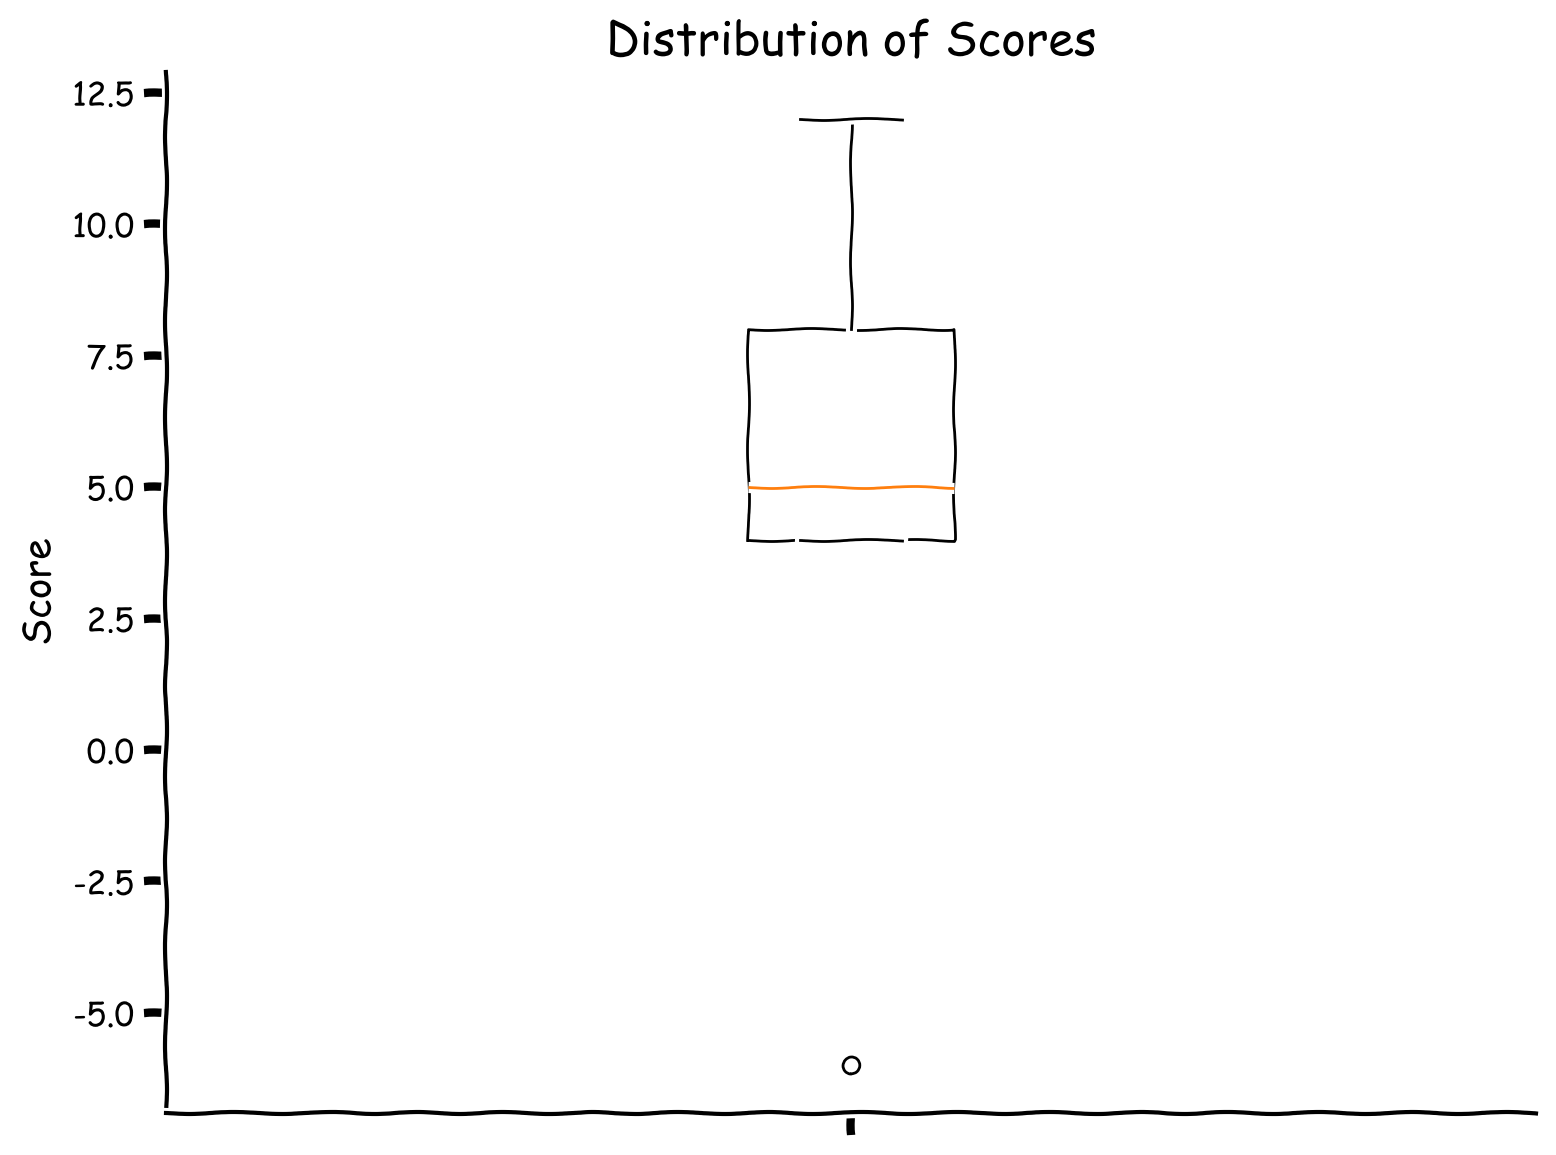

In [16]:
# @markdown Make sure you execute this cell to observe the plot!

set_seed(42)

#define environment
env = HarlowExperimentEnv()

#define agent and optimizer
agent = ActorCritic(hidden_size = 20)
optimizer_func = optim.RMSprop

#calculate score
total_score, scores = evaluate_individual(env, agent, optimizer_func)
print(f"Total score is {total_score}.")
plot_boxplot_scores(scores)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_agents_rate_to_learn")

---

# Section 4: Evolutionary Framework

*Estimated timing to here from start of tutorial: 35 minutes*

This section explores genetic algorithms where we will observe how the Baldwin effect selects for individuals which learn more quickly!

## Coding Exercise 3: Genetic Algorithm

Genetic algorithms (GA) mimic some of the evolutionary processes while generating better and better (= more desired) individuals in the population. At first, we initialize a population which consists of randomly defined agents (so we have a list of `population_size` A2C agents which will in the very end evolve to the agents which quickly learn the new task from Harlow experiment environment). Each epoch (which is the classical term for machine learning) is defined as a generation in GA as we generate new individuals in the population. For each epoch, we choose top-score individuals from the population (of size `tournament_size`; should be big enough to preserve diversity and not too big for selecting top-score ones; it is exactly where selection takes place! and it is the only such place in the whole algorithm) and then we select a random batch of these high-performing individuals of size `parents_num`. From those, we create offspring of size `new_generation_new_individuals` which will replace random individuals from the population . We continue running generations until we are happy with the best-fit individual appearing in the population or until we are running out of time (reached maximum number of generations).

The funniest part happens at the place where we create offsprings - to simluate evoluntionary processes, we randomly select two parents (two agents) and for each of the layers in their networks, we randomly select which one will go to the child (simulating crossing over) and then we add Gaussian noise to each of the layers (simulating mutation). Moreover, GA propose unique feature which can't be that easily introduced in classical gradient descent: we can evolve hyperparameters as well!

The following cell consists of 3 functions: 
- `create_initial_population`, which basically creates population and evaluates each individual as its score;
- `create_new_agent`, which performs crossing over and mutation on parents networks to create one offspring;
- `update_population`, which deletes random individuals in the end of the generation and adds new ones (while also evaluating them during that).

Your task is to complete missing parts in the code and run the total agorithm with the Baldwin effect! The first cell defines noise constants to be used for each of the (hyper)parameters while mutating them.

In [17]:
#for mutation of (hyper)parameters
parameters_noise = 0.02
learning_rate_noise = 0.00005
discount_factor_noise = 0.01
state_value_estimate_cost_noise = 0.05
entropy_cost_noise = 0.001

In [ ]:
###################################################################
## Fill out the following then remove
raise NotImplementedError("Student exercise: complete genetic algorithm functions.")
################################################################### 

def create_initial_population(env, optmizer_func, population_size = 50, hidden_size = 20):
    """
    Creates an initial population of agents.

    Inputs:
    - env (HarlowExperimentEnv): environment.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - population_size (int, default = 50): the size of the initial population.
    - hidden_size (int, default = 20): the size of LSTM layer in A2C agent.
    
    Outputs:
    - population (list): initial population which consists of tuples (agent, score).
    - best_score (int): the best score for the individual in the population registered so far.
    """
    population = []
    total_score = 0
    best_score = 0
    for _ in range(population_size):
        agent = ActorCritic(hidden_size)
        score, _ = evaluate_individual(env, ..., optmizer_func)
        best_score = max(best_score, ...)
        total_score += ...
        population.append((agent, score))
    print(f"Generation: 0, mean population score: {total_score / population_size}, best score: {best_score}")
    return population, best_score

def create_new_agent(agent1, agent2):
    """
    Creates new agent using crossing over technique over layers of network and mutation of the parameters with Gaussian noise.

    Inputs:
    - agent1 (ActorCritic): first parent agent.
    - agent2 (ActorCritic): second parent agent.

    Outputs:
    - new_agent (ActorCritic): new agent which is offspring of the given two.
    """
    #creates agent as copy of the first one
    new_agent = copy.deepcopy(agent1)

    #evolving network parameters with crossing over (over separate layes) & mutating (Gaussian noise)
    for name, module in new_agent.named_modules():
        if isinstance(module, nn.Linear):
            if random.random() < 0.5:
                module.weight.data = agent2._modules[name].....data
                module.bias.data = agent2._modules[name].....data
            #add noise
            module.weight.data += torch.randn_like(module.weight.data) * ...
            module.bias.data += torch.randn_like(module.bias.data) * ...
        elif isinstance(module, nn.LSTM):
            if random.random() < 0.5:
                module.weight_ih_l0.data = agent2._modules[name].....data
                module.weight_hh_l0.data = agent2._modules[name].....data
                module.bias_ih_l0.data = agent2._modules[name].....data
                module.bias_hh_l0.data = agent2._modules[name].....data
            #add noise
            module.weight_ih_l0.data += torch.randn_like(module.weight_ih_l0.data) * ...
            module.weight_hh_l0.data += torch.randn_like(module.weight_hh_l0.data) * ...
            module.bias_ih_l0.data += torch.randn_like(module.bias_ih_l0.data) * ...
            module.bias_hh_l0.data += torch.randn_like(module.bias_hh_l0.data) * ...
    
    #evolving & mutating hyperparameters
    if random.random() < 0.5:
        new_agent.learning_rate = agent2.learning_rate
    new_agent.learning_rate += np.random.normal(size = 1).item() * ...
    new_agent.learning_rate = min(max(new_agent.learning_rate, 0.0001), 0.01)
    if random.random() < 0.5:
        new_agent.discount_factor = agent2.discount_factor
    new_agent.discount_factor += np.random.normal(size = 1).item() * ...
    new_agent.discount_factor = min(max(new_agent.discount_factor, 0.6), 0.99)
    if random.random() < 0.5:
        new_agent.state_value_estimate_cost = agent2.state_value_estimate_cost
    new_agent.state_value_estimate_cost += np.random.normal(size = 1).item() * ...
    new_agent.state_value_estimate_cost = min(max(new_agent.discount_factor, 0.1), 0.7)
    if random.random() < 0.5:
        new_agent.entropy_cost = agent2.entropy_cost
    new_agent.entropy_cost += np.random.normal(size = 1).item() * ...
    new_agent.entropy_cost = min(max(new_agent.discount_factor, 0.0001), 0.05)

    return new_agent

def update_population(env, optimizer_func, population, parents_population, best_score, new_generation_new_individuals = 5):
    """
    Updates population with new individuals which are the result of crossing over and mutation of two parents agents. 
    Removes the same amount of random agents from the population.
    
    Inputs:
    - env (HarlowExperimentEnv): environment.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - population (list): current population which consists of tuples (agent, score).
    - parents_population (list) : parents individuals (part of current population) for creating new individuals.
    - best_score (int): the best score for the individual in the population registered so far.
    - new_generation_new_individuals (int, default = 5): the number of individuals to create (and the old ones to remove).
    """

    #create new individuals
    new_individuals = []
    for _ in range(new_generation_new_individuals):
        agent1, agent2 = random.choices(..., k = 2)
        new_agent = create_new_agent(agent1[0], agent2[0])
        score, _ = evaluate_individual(env, ..., optimizer_func)
        #evaluate whether best score has increased
        best_score = max(score, best_score)
        new_individuals.append((new_agent, score))

    #remove random old individuals
    for _ in range(...):
        population.pop(random.randint(0, len(population) - 1)) 
        
    return population + new_individuals, best_score

In [19]:
# to_remove solution

def create_initial_population(env, optmizer_func, population_size = 50, hidden_size = 20):
    """
    Creates an initial population of agents.

    Inputs:
    - env (HarlowExperimentEnv): environment.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - population_size (int, default = 50): the size of the initial population.
    - hidden_size (int, default = 20): the size of LSTM layer in A2C agent.
    
    Outputs:
    - population (list): initial population which consists of tuples (agent, score).
    - best_score (int): the best score for the individual in the population registered so far.
    """
    population = []
    total_score = 0
    best_score = 0
    for _ in range(population_size):
        agent = ActorCritic(hidden_size)
        score, _ = evaluate_individual(env, agent, optmizer_func)
        best_score = max(best_score, score)
        total_score += score
        population.append((agent, score))
    print(f"Generation: 0, mean population score: {total_score / population_size}, best score: {best_score}")
    return population, best_score

def create_new_agent(agent1, agent2):
    """
    Creates new agent using crossing over technique over layers of network and mutation of the parameters with Gaussian noise.

    Inputs:
    - agent1 (ActorCritic): first parent agent.
    - agent2 (ActorCritic): second parent agent.

    Outputs:
    - new_agent (ActorCritic): new agent which is offspring of the given two.
    """
    #creates agent as copy of the first one
    new_agent = copy.deepcopy(agent1)

    #evolving network parameters with crossing over (over separate layes) & mutating (Gaussian noise)
    for name, module in new_agent.named_modules():
        if isinstance(module, nn.Linear):
            if random.random() < 0.5:
                module.weight.data = agent2._modules[name].weight.data
                module.bias.data = agent2._modules[name].bias.data
            #add noise
            module.weight.data += torch.randn_like(module.weight.data) * parameters_noise
            module.bias.data += torch.randn_like(module.bias.data) * parameters_noise
        elif isinstance(module, nn.LSTM):
            if random.random() < 0.5:
                module.weight_ih_l0.data = agent2._modules[name].weight_ih_l0.data
                module.weight_hh_l0.data = agent2._modules[name].weight_hh_l0.data
                module.bias_ih_l0.data = agent2._modules[name].bias_ih_l0.data
                module.bias_hh_l0.data = agent2._modules[name].bias_hh_l0.data
            #add noise
            module.weight_ih_l0.data += torch.randn_like(module.weight_ih_l0.data) * parameters_noise
            module.weight_hh_l0.data += torch.randn_like(module.weight_hh_l0.data) * parameters_noise
            module.bias_ih_l0.data += torch.randn_like(module.bias_ih_l0.data) * parameters_noise
            module.bias_hh_l0.data += torch.randn_like(module.bias_hh_l0.data) * parameters_noise
    
    #evolving & mutating hyperparameters
    if random.random() < 0.5:
        new_agent.learning_rate = agent2.learning_rate
    new_agent.learning_rate += np.random.normal(size = 1).item() * learning_rate_noise
    new_agent.learning_rate = min(max(new_agent.learning_rate, 0.0001), 0.01)
    if random.random() < 0.5:
        new_agent.discount_factor = agent2.discount_factor
    new_agent.discount_factor += np.random.normal(size = 1).item() * discount_factor_noise
    new_agent.discount_factor = min(max(new_agent.discount_factor, 0.6), 0.99)
    if random.random() < 0.5:
        new_agent.state_value_estimate_cost = agent2.state_value_estimate_cost
    new_agent.state_value_estimate_cost += np.random.normal(size = 1).item() * state_value_estimate_cost_noise
    new_agent.state_value_estimate_cost = min(max(new_agent.discount_factor, 0.1), 0.7)
    if random.random() < 0.5:
        new_agent.entropy_cost = agent2.entropy_cost
    new_agent.entropy_cost += np.random.normal(size = 1).item() * entropy_cost_noise
    new_agent.entropy_cost = min(max(new_agent.discount_factor, 0.0001), 0.05)

    return new_agent

def update_population(env, optimizer_func, population, parents_population, best_score, new_generation_new_individuals = 5):
    """
    Updates population with new individuals which are the result of crossing over and mutation of two parents agents. 
    Removes the same amount of random agents from the population.
    
    Inputs:
    - env (HarlowExperimentEnv): environment.
    - optimizer_func (torch.Optim): optimizer to use for training.
    - population (list): current population which consists of tuples (agent, score).
    - parents_population (list) : parents individuals (part of current population) for creating new individuals.
    - best_score (int): the best score for the individual in the population registered so far.
    - new_generation_new_individuals (int, default = 5): the number of individuals to create (and the old ones to remove).
    """

    #create new individuals
    new_individuals = []
    for _ in range(new_generation_new_individuals):
        agent1, agent2 = random.choices(parents_population, k = 2)
        new_agent = create_new_agent(agent1[0], agent2[0])
        score, _ = evaluate_individual(env, new_agent, optimizer_func)
        #evaluate whether best score has increased
        best_score = max(score, best_score)
        new_individuals.append((new_agent, score))

    #remove random old individuals
    for _ in range(new_generation_new_individuals):
        population.pop(random.randint(0, len(population) - 1)) 
        
    return population + new_individuals, best_score

In order to get the desired results of the genetic algorithm, one should wait for the population to evolve enough :) Unfortunately, we don't have that much time, thus in order to see the initial results we will only run for 1 generation.

In [20]:
#selection - random
set_seed(42)

#define environment
env = HarlowExperimentEnv()

#define agent and optimizer
agent = ActorCritic(hidden_size = 20)
optimizer_func = optim.RMSprop

#GA consts
num_generations = 1
tournament_size = 20
parents_size = 4
new_generation_new_individuals = 5

mean_population_scores = []

#create population
population, best_score = create_initial_population(env, optimizer_func)

for generation in range(1, num_generations):

  #at first, select top individuals from population (of size tournament_size) (selectivy happens here)
  sorted_population = sorted(population, key=lambda x: x[1], reverse=True)
  tournament_population = sorted_population[:tournament_size]

  #random choice of parents from tournament population
  parents_population = random.choices(tournament_population, k = parents_size)

  #update population
  population, best_score = update_population(env, optimizer_func, population, parents_population, best_score)

  mean_population_scores.append(np.mean([agent_score[1] for agent_score in population]))
  print(f"Generation {generation}, mean population score: {mean_population_scores[-1]}, best score: {best_score}")

Generation: 0, mean population score: 49.72, best score: 100


If you change `num_generations` to 800 in the previous code cell, the plot for the mean score in the population will roughly take the following form.

![Picture which depicts the plot of mean scores per generation.](static/evolution.png)

In the very start of the tutorial, we have downloaded the best agent we obtained from the training on 800 generations (you can get the same if you add extra infrastructure code around to "catch" such agent as soon as score reaches some threshold value; in this case, it can be even set up to 200). In the next section we are going to compare its performance with randomly initialized agent and observe that, indeed, during evolutionary processes we developed agents with parameters that are able to learn more quickly.

In [21]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_genetic_algorithm")

## Think 1: Evolutionary Theories in Code

In this section we have observed how the Baldwin effect evolves individuals' parameters so that they quickly learn. We would like to propose you to think about other evolutionary biology ideas. For example, what would this process look like if we took a [Lamarckian approach](https://en.wikipedia.org/wiki/Lamarckism)? Discuss what should be changed in the implementation to use these ideas (simply put, what parts of code should be change to reflect their essence)?

Take time to think and then discuss as a group

In [22]:
#to_remove explanation

"""
Discussion: What should be changed in the implementation approach (code base) to reflect Lamarckian evolution?

For Lamarckian evolution, we might want to change the base parameters of the agent each time it learns a new task; this way the learned benefits are inherited by the next generation.""";

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_evolutionary_theories_in_code")

---

# Section 5: Newbie & Experienced Bird

*Estimated timing to here from start of tutorial: 45 minutes*

This section proposes comparison of the evolutionary trained (found) agent which performs the Harlow experiment with the previously-mentioned model which is initialized from scratch (and thus only trains on the given task but does not benefit from meta-learning).

Total score of newbie agent is 54.
Total score of experienced agent is 180.


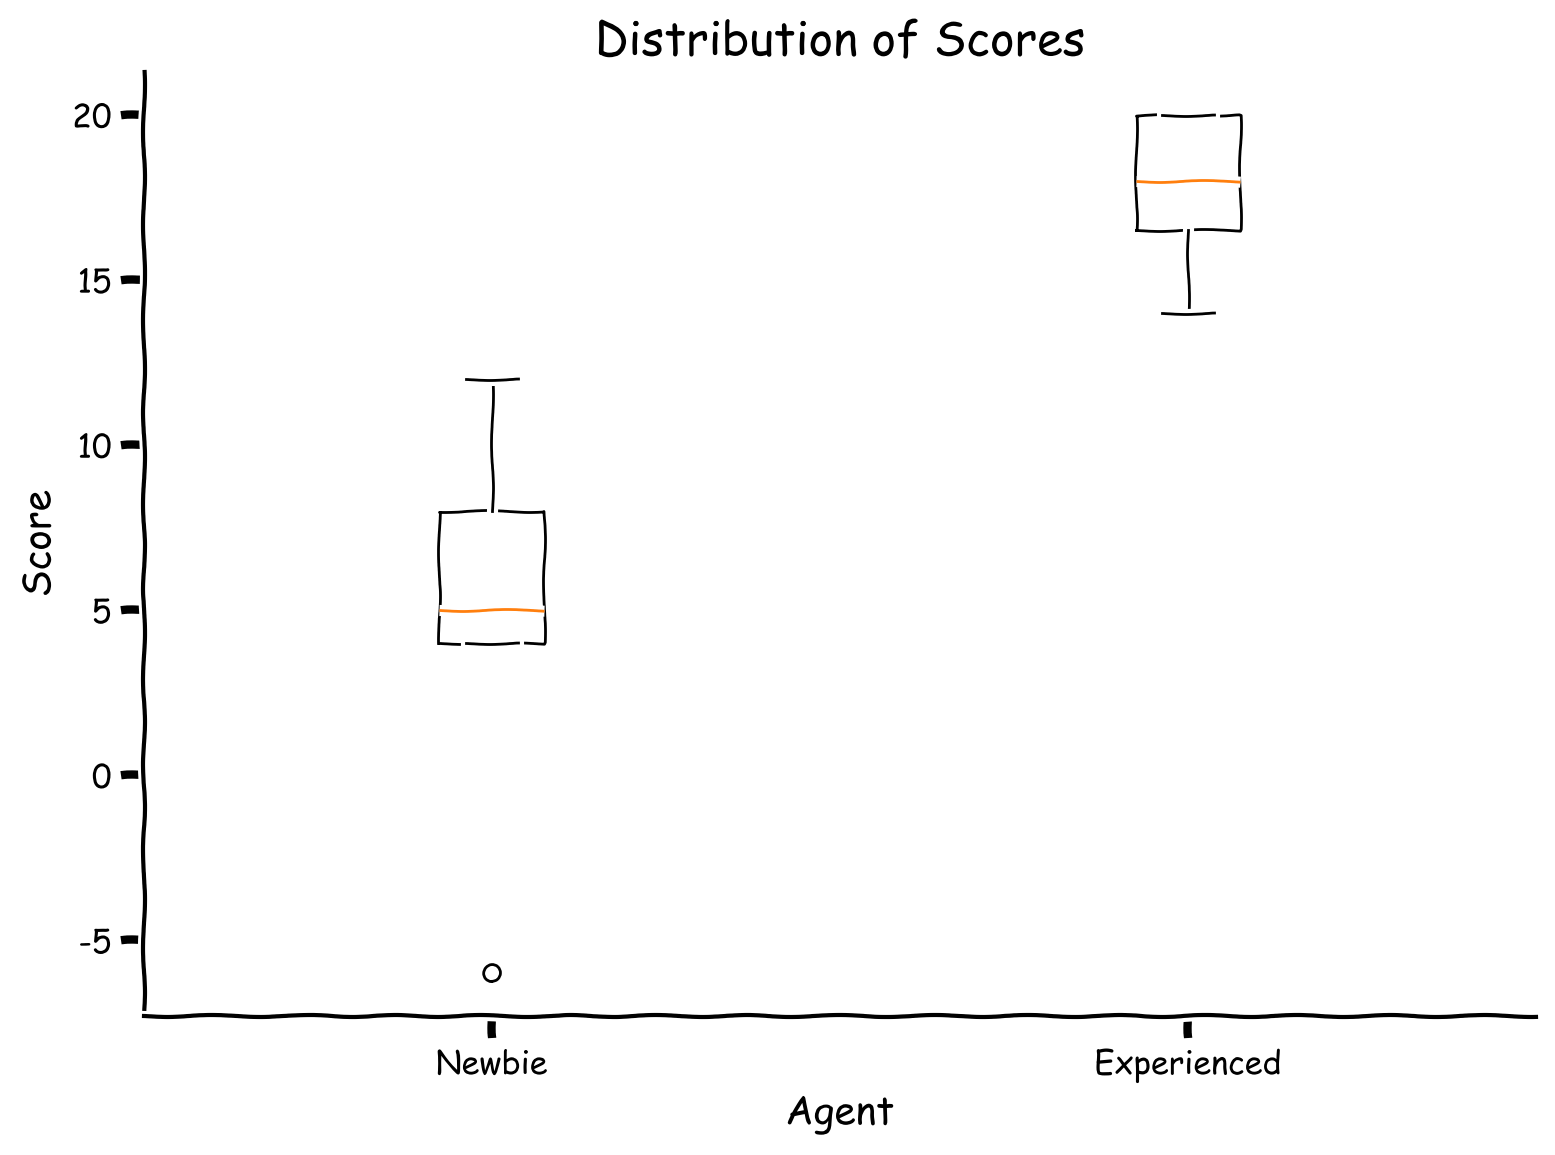

In [23]:
# @markdown Make sure you execute this cell to observe the plot!
set_seed(42)

#define environment
env = HarlowExperimentEnv()

#define newbie agent and optimizer
newbie = ActorCritic(hidden_size = 20)
optimizer_func = optim.RMSprop

#calculate newbie's score
total_score, newbie_scores = evaluate_individual(env, newbie, optimizer_func)
print(f"Total score of newbie agent is {total_score}.")

#define experienced agent
experienced = torch.load("Evolution.pt")

#calculate experienced's score
total_score, experienced_scores = evaluate_individual(env, experienced, optimizer_func)
print(f"Total score of experienced agent is {total_score}.")

plot_two_boxplot_scores(newbie_scores, experienced_scores)

In [ ]:
# @title Submit your feedback
# content_review(f"{feedback_prefix}_newbie_experienced")

---
# Summary

*Estimated timing of tutorial: 50 minutes*

Here is a summary of what we've learned:

1. The Baldwin effect says that evolution will select organisms that are good at learning.

2. We can use evolutionary/genetic algorithms to replicate this process. This is the "outer loop" of a meta-learning problem

3. To be more biologically plausible, we can use reinforcement learning as the inner loop.

4. This process creates agents that can quickly find the rewarding object in a Harlow experiment. 